In [10]:
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import grid_utils
import os
import grid as stimgrid
import subtract_utils

In [61]:
results_path = "220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_planes_subtractr_caviar_results.npz"

results = np.load(results_path, allow_pickle=True)
model = results['model'].item()
dset_name = os.path.basename(results_path).split('.')[0]

In [62]:
weights = model.state['mu'].reshape(26,26,5)

ValueError: cannot reshape array of size 676 into shape (26,26,5)

In [63]:
def make_grid_waveforms(model, psc, I, grid=None):
    if grid is None:
        grid = stimgrid.make_default_grid()
    
    # pull I vector from first plane, use it to find number of unique powers
    # for this dataset
    powers = np.unique(I) # powers for first plane
    
    psc_length = psc[0].shape[-1]
    grid_dims = grid.dims
    grid_waveforms = np.zeros((len(powers), *grid_dims, psc_length)) # e.g 2, 26, 26, 5, 900

    for power_idx, power in enumerate(powers):
        
        # extract lambda and pscs for current power
        these_stims = I == power
        
        lam_curr = model.state['lam'][:, these_stims]
        den_psc_curr = psc[these_stims, :]
        
        curr_waveforms = grid_utils.estimate_spike_waveforms(lam_curr, den_psc_curr)
        curr_waveforms = curr_waveforms.reshape(grid_dims[0], grid_dims[1], grid_dims[2], psc_length)
        curr_waveforms = np.swapaxes(curr_waveforms, 0, 1)

        grid_waveforms[power_idx,:,:,:,:] = curr_waveforms
        
    return grid_waveforms

In [64]:
g = stimgrid.make_manual_grid(
        xlims=(194, 324),
        ylims=(194, 324),
        zlims=(-75, 50),
        radial_spacing=5,
        axial_spacing=25
    )
g.dims
# model.state['lam'].shape

[26, 26, 5]

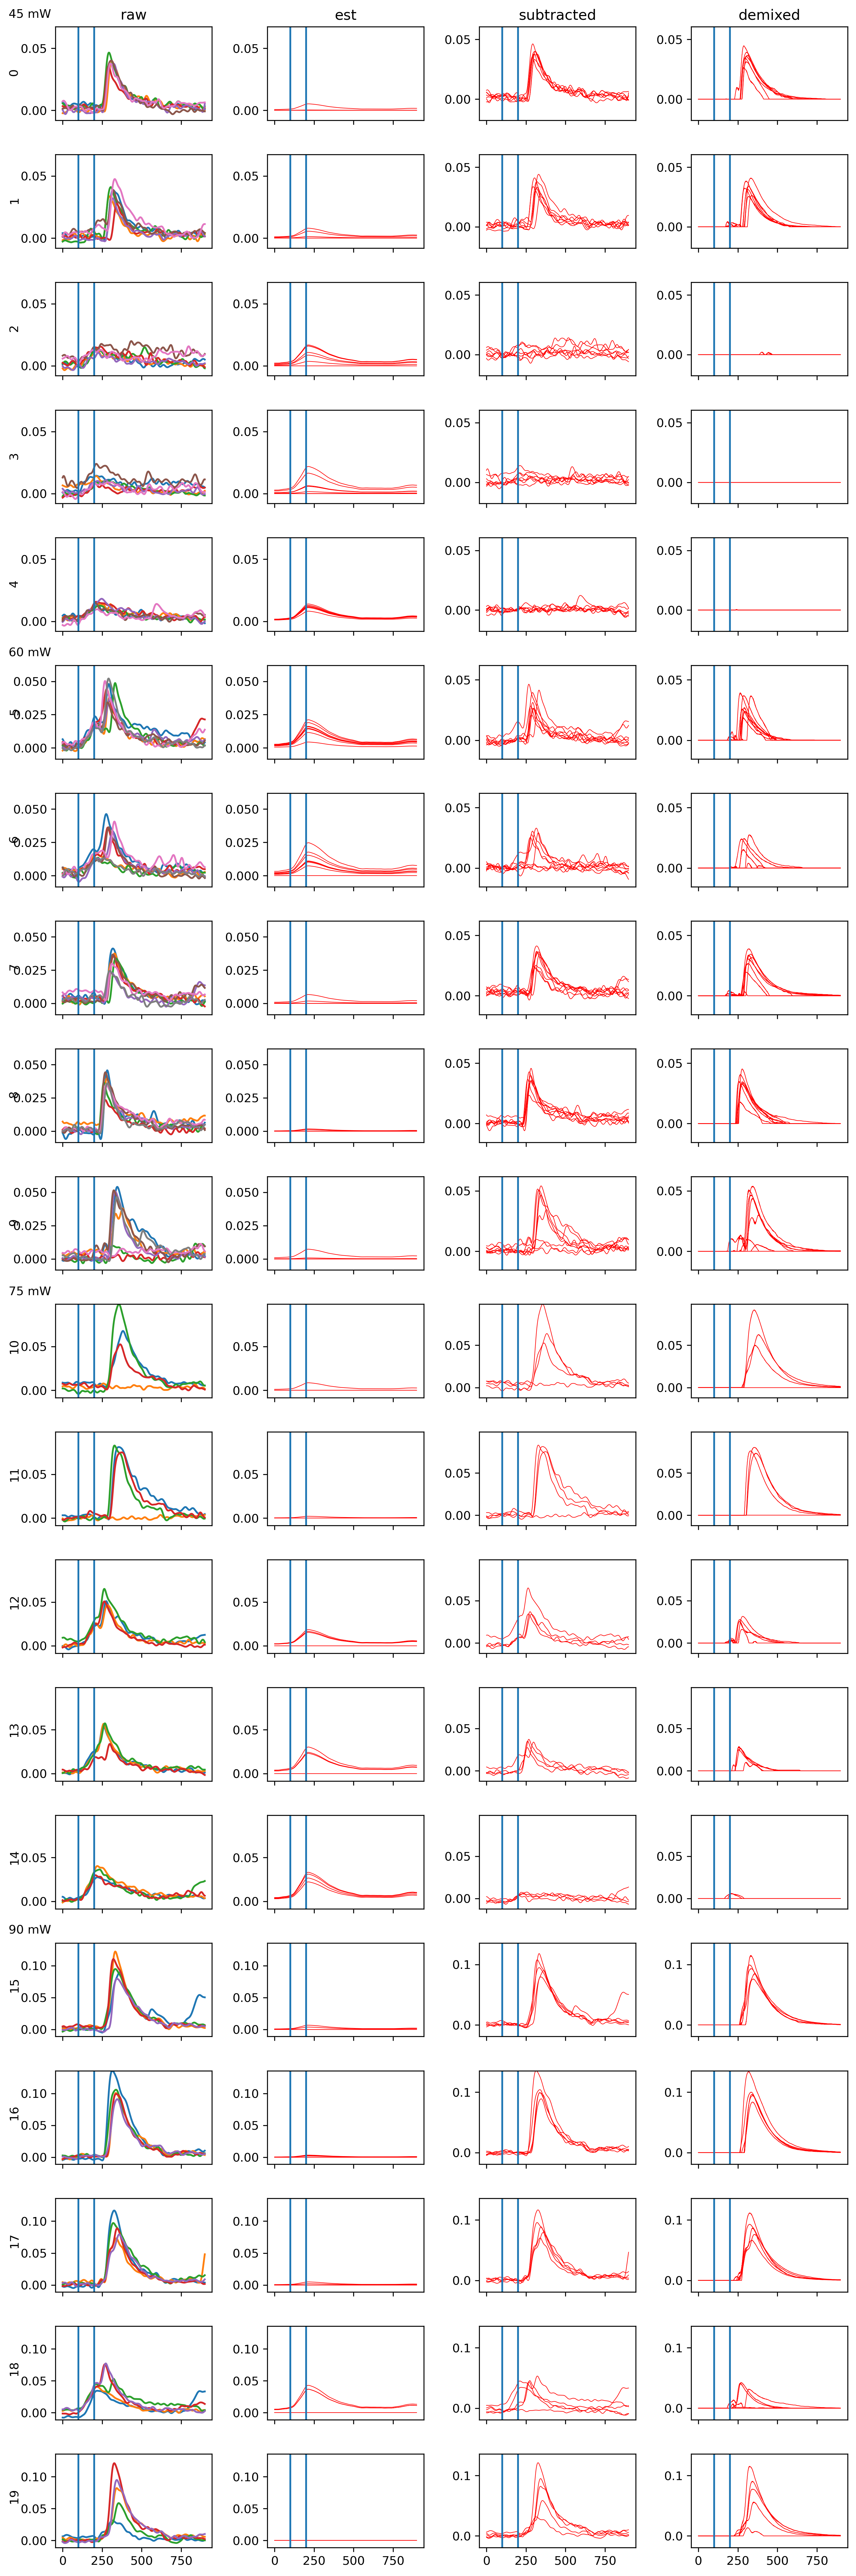

In [65]:
fig3, axs = subtract_utils.plot_subtraction_comparison(
        results['raw_tensor'],
        [results['est_tensor']],
        [results['subtracted_tensor']],
        [results['demixed_tensor']],
        powers=np.unique(results['I']),
        num_plots_per_power=5,
)
plt.savefig(dset_name + '_traces_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()

In [66]:
grid_waveforms = make_grid_waveforms(model, results['demixed_matrix'], results['I'], grid=g)
grid_latencies = grid_utils.make_grid_latencies(grid_waveforms)

ValueError: cannot reshape array of size 608400 into shape (26,26,5,900)

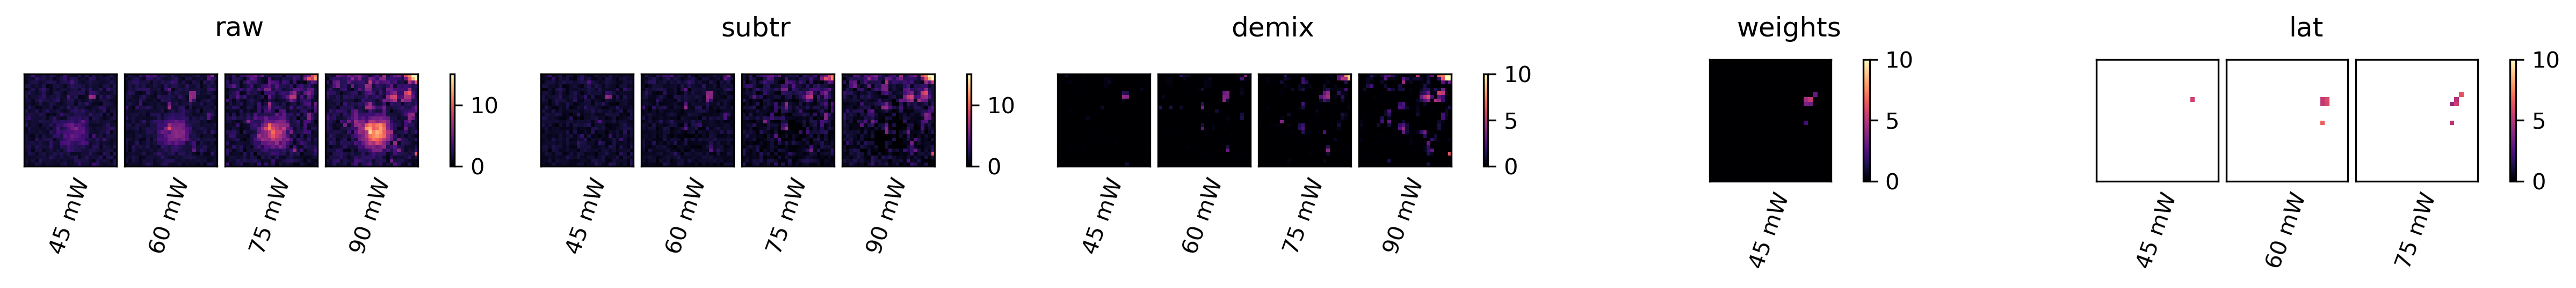

In [67]:
num_planes = results['raw_map'].shape[-1]
fig2 = plt.figure(figsize=(4 * 5, num_planes), dpi=300, facecolor='white')

lat = grid_latencies.copy()
lat[lat == 0] = np.nan
lat -= 5
lat = np.swapaxes(lat, 1, 2)

grid_utils.plot_multi_means(fig2,
    [results['raw_map'],
    results['subtracted_map'],
    results['demixed_map'],
    weights[None,...],
    lat], np.arange(num_planes),
#     map_names=['subtracted'],
    cmaps=['magma', 'magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['raw', 'subtr', 'demix', 'weights', 'lat'],
    vranges=[(0,15), (0,15), (0,10), (0,10), (0,10)],
    powers=np.unique(results['I'])
    )

plt.savefig(dset_name + '_maps.png', bbox_inches='tight')


In [68]:
def plot_spike_inference_with_waveforms(den_psc, stim, I, model, waveforms, latencies,
                         spike_thresh=0.01, save=None, ymax=None, n_plots=15, num_trials=30, 
                         weights=None, col_width=10.5, row_height=0.6, order=None,
                         title=None, raw_psc=None, fontsize=14, draw_stim_start=True):
    N = stim.shape[0]
    K = den_psc.shape[0]
    trial_len = 900
    normalisation_factor = np.max(np.abs(den_psc))
    trace_linewidth = 0.65
    ymax = 1.05
    ymin = -0.05 * ymax
    
    mu = model.state['mu']
    mu /= np.max(mu)
    lam = model.state['lam']
    z = model.state['z']

    fig = plt.figure(figsize=(col_width, row_height * n_plots * 1.5), dpi=300, facecolor='white')
    
    # one columns for inferred waveforms
    powers = np.unique(I)
    width_ratios = np.zeros(len(powers) + 1)
    width_ratios[0:len(powers)] = 1
    width_ratios[-1] = n_plots
    gs = fig.add_gridspec(ncols=len(powers) + 1, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=width_ratios)
        
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m,-1])
        
        if title is not None and m == 0:
            plt.title(title, fontsize=fontsize, y=1.5)
            
        
        trials_per_power = num_trials // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim[n] == pwr)[0][:trials_per_power]])
            
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_psc[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), num_trials])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        if raw_psc is not None:
            this_y_psc_raw = raw_psc[stim_locs].flatten()/normalisation_factor

        plt.xlim([0, trial_len*n_repeats])
        
        # if we have ground truth weights
        if weights is None:
            trace_col = 'k'
        else:
            trace_col = 'k' if weights[n] != 0 else 'gray'
            
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam[n, stim_locs][tb] * mu[n], zorder=-5)

            if draw_stim_start:
                plt.axvline(x=100 + trial_len * tb,
                            color='grey',
                            linewidth=trace_linewidth, linestyle='-.')                 
            if z[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                
            # Plot power changes
            if (m == 0) and (I[stim_locs][tb] != I[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        if raw_psc is not None:
            plt.plot(this_y_psc_raw, color='black', linewidth=trace_linewidth, alpha=0.9)
            
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
#         plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
        
    if waveforms is not None:
        ### Inferred PSC waveforms ###
        waveform_colors=['blue','green','purple','red']

        for m in range(n_plots):
            n = order[m]
            

            for power_idx, power in enumerate(powers):
                ax = fig.add_subplot(gs[m,power_idx])
                
                plt.plot(waveforms[power_idx, n, :]/normalisation_factor,
                         color=waveform_colors[power_idx], linewidth=0.8 * trace_linewidth)
                
                # draw vertical line at inferred latency, first convert to index
                sample_khz = 20
                samples_per_sec = sample_khz * 1e3
                secs_per_sample = 1 / samples_per_sec
                msecs_per_sample = secs_per_sample * 1e3
                plt.axvline(x=(latencies[power_idx, n] / msecs_per_sample),
                            color=waveform_colors[power_idx],
                            linewidth=trace_linewidth, linestyle='-.')

                for loc in ['top', 'right', 'left', 'bottom']:
                    plt.gca().spines[loc].set_visible(False)
                plt.xticks([])
                plt.yticks([])
                plt.ylim([ymin, ymax])

    return fig

In [69]:
# for sorting by max observed charge
charge_per_location = np.nansum(results['raw_tensor'][-1,...], axis=(-1, -2)).ravel()
charge_order = np.argsort(charge_per_location)[::-1]

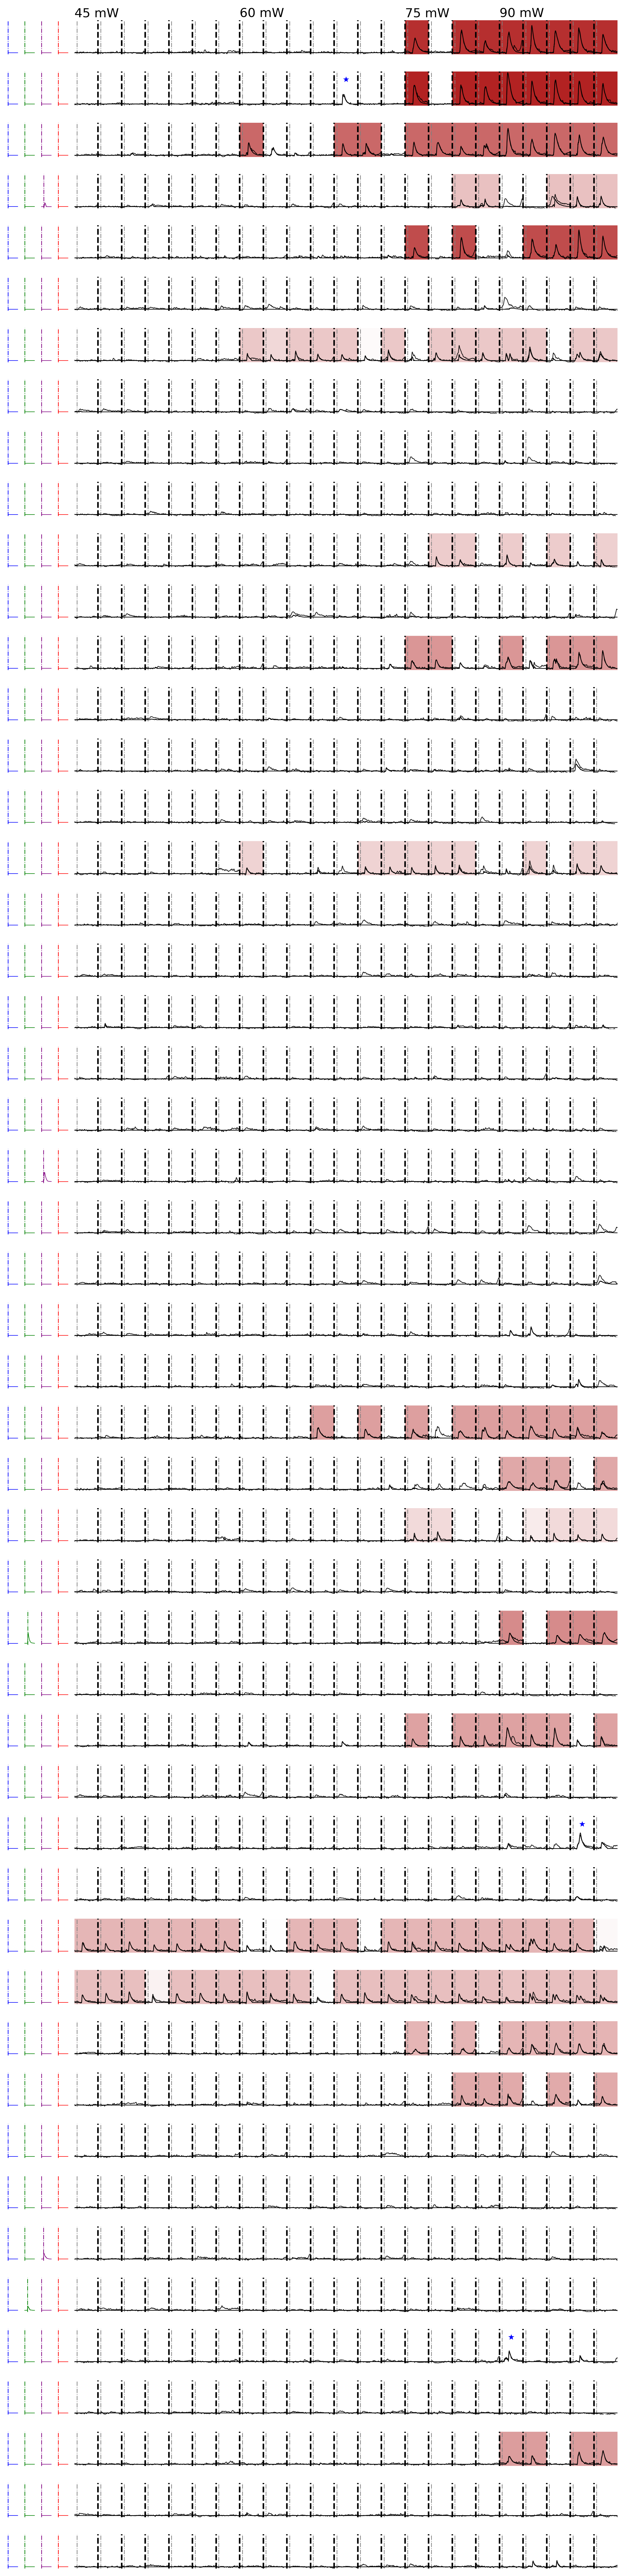

In [70]:
fontsize=14
num_powers = len(np.unique(results['I']))
fig = plot_spike_inference_with_waveforms(results['demixed_matrix'], results['stim_mat'], results['I'], results['model'].item(),
    waveforms=np.swapaxes(grid_waveforms, 1,2).reshape(num_powers, -1, 900),
    latencies=np.swapaxes(grid_latencies, 1,2).reshape(num_powers, -1,),
    # order = np.argsort(model.state['mu'])[::-1],
    order = charge_order,
    raw_psc=results['subtracted_matrix'],
    n_plots=50)
plt.savefig(dset_name + '_checker.png', bbox_inches='tight')